Vamos a crear un modelo para predecir cuando un cliente dejará propina o no. Los conductores que no recibán propinas estarán decepcionados cuando un cliente no les de propina si la aplicación le ha informado previamente que sí dejará dicha propina. Si ocurriera a menudo, los conductores podrían no confiar en la aplicación. Es improbable que los conductores recojan a personas de las que se predice que no dejarán propina. Los clientes tendrán dificultades para encontrar un taxi que les recoja y podrían enfadarse con la compañía. Incluso cuando el modelo sea correcto, las personas que no puedan permitirse dejar propina tendrán más dificultades para conseguir taxis, lo que limita la accesibilidad del servicio de taxi a quienes pagan más.

Podemos construir un modelo que prediga cuáles son los clientes más generosos. Así se podría cumplir el objetivo de ayudar a los taxistas a aumentar sus ingresos por propinas y evitar al mismo tiempo la exclusión injusta de ciertas personas del uso de taxis.

In [12]:
# Importar paquetes y librerias
import numpy as np
import pandas  as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance

In [13]:
pd.set_option('display.max_columns', None)

In [14]:
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Importamos las predicciones del anterior código
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

In [15]:
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


El dataset de nyc_preds_means son predicciones obtenidas con el modelo que hemos creado en modelo anterior.

In [16]:
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


In [17]:
# Unimos los dataset
df0 = df0.merge(nyc_preds_means,
               left_index = True,
               right_index = True)
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


In [18]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

Sabemos del análisis anterior que los clientes que dejan propinas son mayoritariamente los que pagan con tarjeta. Para alcanzar el objetivo vamos a hacer el modelo para únicamente clientes que paguen con tarjeta de crédito. Recordar que en el dataset el pago con tarjeta de credito viene codificado como tipo de pago 1.

In [19]:
# Nos quedamos con los que solo han pagado con tarjeta de crédito
df1 = df0.copy()

df1 = df1[df1['payment_type'] == 1]

Vamos a crear una columna con el porcentaje del pago total que son propinas. Esto nos servirá para organizar los clientes en clientes "generosos" y el resto. 

In [20]:
# Creamos la columna del porcentaje de propinas
df1['tip_percent'] = round(df1['tip_amount']/(df1['total_amount'] - df1['tip_amount']), 3)

Para los clientes generosos vamos a establecer un porcentaje mínimo del 20%. Creamos la columna `generous` de manera que aparecerá un 1 cuando el cliente sea generoso y un cero cuando no.

In [21]:
# Creamos la columna de clientes generosos
df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1


Convertimos el tipo de dato de las columnas `tpep_pickup_datetime` y `tpep_dropoff_datetime` a tipo date.

In [22]:
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'])

A continuación vamos a crear cuatro nuevas columnas que representan franjas horarias. Cada columna contendrá valores binarios como la columna `generous` que indique si un viaje comenzó en una de esas franjas horarias.

`am_rush` = [06:00&ndash;10:00]  
`daytime` = [10:00&ndash;16:00]  
`pm_rush` = [16:00&ndash;20:00]  
`nighttime` = [20:00&ndash;06:00]

In [23]:
# Columna día
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

In [24]:
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

In [25]:
# am_rush [06:00–10:00]
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [26]:
# Aplicamos la función al dataset
df1['am_rush'] = df1.apply(am_rush, axis = 1)
df1['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

In [27]:
# daytime [10:00–16:00]
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else: 
        val = 0
    return val

In [28]:
df1['daytime'] = df1.apply(daytime, axis = 1)
df1['daytime'].head()

0    0
1    1
2    0
3    1
5    0
Name: daytime, dtype: int64

In [29]:
# pm_rush [16:00–20:00]
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [30]:
df1['pm_rush'] = df1.apply(pm_rush, axis = 1)
df1['pm_rush'].head()

0    0
1    0
2    0
3    0
5    0
Name: pm_rush, dtype: int64

In [31]:
# nighttime() [20:00–06:00]
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [32]:
df1['nighttime'] = df1.apply(nighttime, axis = 1)
df1['nighttime'].head()

0    0
1    0
2    0
3    0
5    1
Name: nighttime, dtype: int64

In [33]:
# Creamos la columna mes
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [34]:
df1.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,0,0,1,mar


Vamos a eliminar las columnas redundantes y las columnas que sabemos que no tendremos cuando se implante el modelo. Esto incluye información como tipo de pago, distance del viaje, importe de la propina, porcentaje de la propina, importe total, importe de peaje, etc. La variable `generous` debe permanecer pues será la variable que predicirá el modelo por lo que hay que usarla para su entrenamiento.

In [35]:
# Eliminamos columnas que no nos interesan para la creación del modelo
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int32  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int32(1), int64(9), object(2)
memory usage: 1.8+ MB


Muchas de las columnas son categóricas y tendrán que ser convertidas a binario. Algunas de estas columnas como `RatecodeID` y las ubicaciones de recogida y entrega son númericas pero la información es categórica por lo que hay que convertir el tipo de dato a string para que la funciòn `get_dummies()` las reconozca.

In [36]:
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID']

for col in cols_to_str:
    df1[col] = df1[col].astype('str')

In [37]:
# Creamos dummies
df2 = pd.get_dummies(df1, drop_first = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Columns: 347 entries, VendorID to month_sep
dtypes: float64(3), int32(1), int64(6), uint8(337)
memory usage: 6.1 MB


In [38]:
df2['generous'].value_counts(normalize = True)

1    0.526368
0    0.473632
Name: generous, dtype: float64

Para determinar una métrica debemos considerar el coste de ambos tipos de error:

- Falsos positivos: el modelo predice una propina superior al 20% pero el cliente no da dicha propina

- Falsos negativos: el modelo predice un propina inferior al 20% pero el cliente da una superior a dicho porcentaje.

Los falsos positivos son malos para los conductores pues esperarán una propina generosa la cual no obtendrán al finalizar el viaje. 

Los falsos negativos son peores para los clientes porque el conductor puede elegir a otro cliente en vez de a él al marcarle la aplicación que no dará una propina generosa.

### Construimos el modelo.

In [39]:
# Aislamos la variable y
y = df2['generous']

# Aislamos las variables X
X = df2.drop('generous', axis = 1)

# Separamos en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [40]:
rf = RandomForestClassifier(random_state = 42)
 
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf1 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'f1')

In [41]:
rf1.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'precision', 'recall', 'accuracy', 'f1'})

In [42]:
rf1.best_score_

0.7194058935268377

In [43]:
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Vamos usar una función obtenida del curso de Google Advanced Data Analyst en Coursera.

In [44]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [45]:
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.680236,0.763403,0.719406,0.684491


Las puntuaciones de F1, precisión y recall son bajas. El modelo no es lo suficientemente bueno con los datos que tenemos. Se podría intentar mejorar el modelo con otros hiperparámetros pero en este caso ya hemos usado los mejores para este modelo por lo que no vamos a obtener ninguna mejora significativa.

In [46]:
rf_preds = rf1.best_estimator_.predict(X_test)

La función `gest_test_scores` también ha sido obtenida del mismo curso que la función `make_results`.

In [47]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [48]:
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.680236,0.763403,0.719406,0.684491
0,RF test,0.657822,0.760870,0.705603,0.674746


Vamos a usar un modelo XGBoost para intentar mejorar las puntuaciones.

In [49]:
xgb = XGBClassifier(objective = 'binary:logistic', random_state = 0)

cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [50]:
xgb1.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

In [51]:
xgb1.best_score_

0.7015491167766134

In [52]:
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

In [53]:
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.680236,0.763403,0.719406,0.684491
0,RF test,0.657822,0.760870,0.705603,0.674746
0,XGB CV,0.674793,0.730643,0.701549,0.670652


In [54]:
xgb1_preds = xgb1.best_estimator_.predict(X_test)

In [55]:
xgb_test_scores = get_test_scores('XGB test', xgb1_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.680236,0.763403,0.719406,0.684491
0,RF test,0.657822,0.760870,0.705603,0.674746
0,XGB CV,0.674793,0.730643,0.701549,0.670652
0,XGB test,0.652198,0.739770,0.693229,0.664592


Despues de evaluar ambos modelos podemos ver que aunque es por una diferencia mínima, el modelo RandomForest es mejor.

Vamos ahora a generar una Confusion matrix para observar como se reparten los errores y aciertos del modelo.

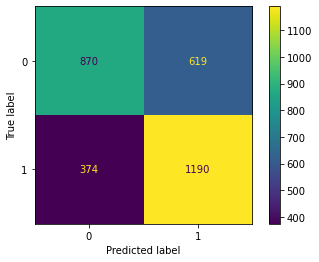

In [56]:
cm = confusion_matrix(y_test, rf_preds, labels = rf1.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf1.classes_)
disp.plot(values_format = '');

El modelo tiene casi el doble de probabilidades de predecir un falso positivo que de predecir un falso negativo. Por lo tanto, los errores de tipo I son más frecuentes. Esto es menos deseable, porque es mejor que un conductor se sorprenda gratamente con una propina generosa cuando no la esperaba a que se decepcione con una propina baja cuando esperaba una generosa. Sin embargo, el rendimiento global de este modelo es satisfactorio.

Utilizamos el atributo `feature_importances_` para inspeccionar las características del modelo final. 

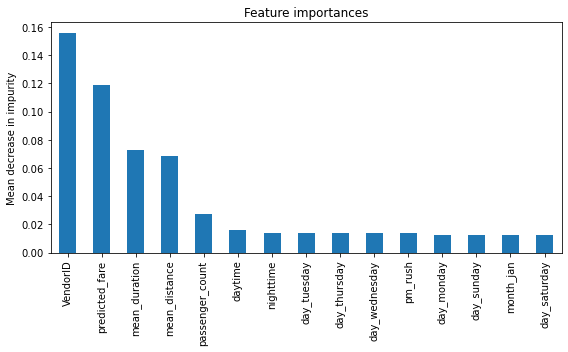

In [57]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

Desgraciadamente el modelo RandomForest no es el algoritmo de aprendizaje más transparente- Sabemos que `VendorID`, `predicted_fare`, `mean_duration` y `mean_distance` son las características del modelo más importantes pero no sabemos como influyen estas en las propinas. Es interesante que `VendorID` sea la característica más importante, esto nos muestra que uno de los proveedores atra a más clientes generosos que el otro.  

Recuerde que, a veces, sus datos simplemente no servirán para predecir el objetivo elegido. Esto es habitual. El aprendizaje automático es una herramienta poderosa, pero no es magia. Si sus datos no contienen una señal predictiva, ni siquiera el algoritmo más complejo podrá ofrecer predicciones coherentes y precisas. No tenga miedo de sacar esta conclusión. Incluso si no puede utilizar el modelo para hacer predicciones sólidas, ¿ha sido en vano el trabajo realizado? ¿Qué conclusiones puede transmitir a las partes interesadas?